<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/eywalker/LVIV-2021/blob/main/notebooks/DeepLearing%20in%20Neuroscience.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/eywalker/LVIV-2021/blob/main/notebooks/DeepLearing%20in%20Neuroscience.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Welcome to Deep Learning in Neuroscience by Edgar Y. Walker

This is a Jupyter notebook to accompany the course on "Deep Learning in Neuroscience" taught as part of the Lviv Data Science Summer School 2021. This notebook as well as any other relevant information can be found in the [GitHub repository](https://github.com/eywalker/lviv-2021)!

In this course, we will learn how deep learning is getting utilized in studying neuroscience, specifically in building models of neurons to complex sensory inputs such as natural images. We will start by going through some neuroscience primer. We will then get our hands dirty by taking real neuronal responses recorded from mouse primary visual cortex (V1) as the mouse observes a bunch of natural images and developing a model to predict these responses. By the end of this course, you will gain some basic familiarity in utilizing deep learning models to predict responses of 1000s of neurons to natural images!

## Preparing the environment

#### <font color='red'>NOTE: Please run this section at the very beginning of the first session!</font>

Before we get to dive in and learn how deep learning is used in neuroscience and get your first neural predictive model trained, we need to install some prerequisite packages and download some neuronal data!

### Getting the code

We are going to primarily use [PyTorch](https://pytorch.org) to build, train and evaluate our deep learning models and I am going to assume some familiarity with PyTorch already.

Also to be able to handle the dataset containing neuronal activities, we are going to make our life easier by using a few existing libraries. I have prepared a library called [lviv2021](https://github.com/eywalker/lviv2021). This library has a dependency on [neuralpredictors](https://github.com/sinzlab/neuralpredictors), which is a collection of PyTorch layers, tools and other utilities that would prove helpful to train networks to predict neuronal responses.

Let's go ahead and install this inside the Colab environment.

In [1]:
# Install PyTorch dependency
!pip3 install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
    
# Install 
!pip3 install git+https://github.com/eywalker/lviv-2021.git

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1.9 MB 7.5 MB/s 
  Cloning https://github.com/sinzlab/neuralpredictors.git (to revision v0.0) to /tmp/pip-req-build-v6c91am7
  Running command git clone -q https://github.com/sinzlab/neuralpredictors.git /tmp/pip-req-build-v6c91am7
  Running command git checkout -b v0.0 --track origin/v0.0
  Switched to a new branch 'v0.0'
  Branch 'v0.0' set up to track remote branch 'v0.0' from 'origin'.
  Created wheel for neuralpredictors: filename=neuralpredictors-0.0.3-py3-none-any.whl size=56066 sha256=8b5329ddfdd5504177e8c77abcf15b941bb1abd1933fc223750bf1ff7ba86c5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-a20585dv/wheels/2b/55/61/c9d55e5d782d397dde737beea8c31e670fd96ca541b7fd3250
Successfully built neuralpredictors


### Getting the dataset

We are going to use the dataset made available for our recent paper [Lurz et al. ICLR 2021](https://github.com/sinzlab/Lurz_2020_code), predicting responses of mouse visual cortex to natural images. 

The dataset can take anywhere from 5-10 min to download, so please be sure to **run the following at the very beginning of the session!** We are going to first spend some time learning the basics of computational neuroscience in the study of system identification. It would be best that you let the download take place while we go over the neursocience primer so that it will be ready when we come back here to get our hands dirty!

To download the data, simply execute the following cell, and let it run till completion.

In [1]:
!mkdir /data
!git clone https://gin.g-node.org/cajal/Lurz2020.git /data

mkdir: cannot create directory ‘/data’: File exists
Cloning into '/data'...
remote: Enumerating objects: 23150, done.                                            
remote: Counting objects: 100% (23150/23150), done.                                  
remote: Compressing objects: 100% (11714/11714), done.                                  
remote: Total 23150 (delta 11436), reused 23134 (delta 11434)    
Receiving objects: 100% (23150/23150), 252.05 MiB | 506.00 KiB/s, done.
Resolving deltas: 100% (11436/11436), done.
Checking out files: 100% (24035/24035), done.


# Developing models of neural population responses to natural images

Now that you have been primed with just enough background neuroscience, let's get our hand dirty and try to build our first neural predictive models.

As part of the setup, we have downloaded a 2-photon imaging dataset from mouse primary visual cortex as we present 1000s of natural images (if not done yet, please do so immediately by stepping through the beginning sections of this notebook).

In [118]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

## Navigating the neuroscience data

As with any data science project, you must start by understanding your data! Let's take some time to navigate the data you downloaded.

In [3]:
ls ./data/static20457-5-9-preproc0/

change.log  config.json  data/  meta/


In [5]:
ls ./data/static20457-5-9-preproc0/data

behavior/  images/  pupil_center/  responses/


In [18]:
ls ./data/static20457-5-9-preproc0/data/responses | head -30

0.npy
1.npy
10.npy
100.npy
1000.npy
1001.npy
1002.npy
1003.npy
1004.npy
1005.npy
1006.npy
1007.npy
1008.npy
1009.npy
101.npy
1010.npy
1011.npy
1012.npy
1013.npy
1014.npy
1015.npy
1016.npy
1017.npy
1018.npy
1019.npy
102.npy
1020.npy
1021.npy
1022.npy
1023.npy
ls: write error: Broken pipe


In [17]:
ls ./data/static20457-5-9-preproc0/data/images | head -30

0.npy
1.npy
10.npy
100.npy
1000.npy
1001.npy
1002.npy
1003.npy
1004.npy
1005.npy
1006.npy
1007.npy
1008.npy
1009.npy
101.npy
1010.npy
1011.npy
1012.npy
1013.npy
1014.npy
1015.npy
1016.npy
1017.npy
1018.npy
1019.npy
102.npy
1020.npy
1021.npy
1022.npy
1023.npy
ls: write error: Broken pipe


You can see that both responses and contained in collections of `numpy` files named like `1.npy` or `31.npy`. The number here corresponds to a specific **trial** or simply different image presentation during an experiment.

Let's take a look at some of these files.

### Loading data files one at a time

Let's pick some trial and load the image as well as the response

In [45]:
trial_idx = 1100
trial_image = np.load(f'./data/static20457-5-9-preproc0/data/images/{trial_idx}.npy')
trial_responses = np.load(f'./data/static20457-5-9-preproc0/data/responses/{trial_idx}.npy')

The image is shaped as $\text{channel} \times \text{height} \times \text{width}$

In [46]:
trial_image.shape

(1, 36, 64)

(-0.5, 63.5, 35.5, -0.5)

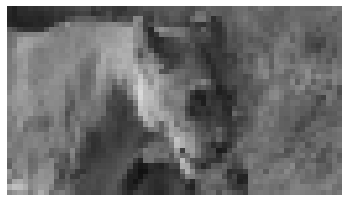

In [48]:
plt.imshow(trial_image.squeeze(), cmap='gray', vmin=0, vmax=255)
plt.axis('off')

In contrast, the shape of `trial_response` is simply the number of neurons

In [50]:
trial_responses.shape

(5335,)

In [117]:
trial_responses.min() # responses are practically always >= 0

-5.409307320414307e-10

In [62]:
trial_responses.max()

53.39189366955226

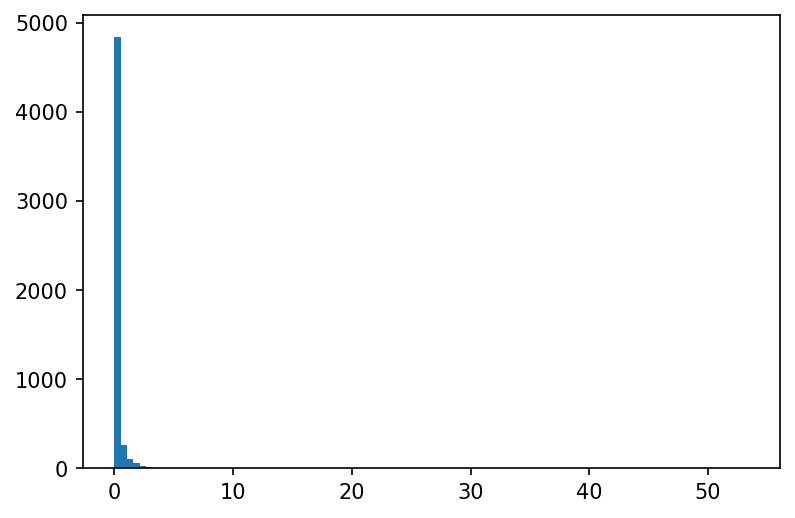

In [65]:
fig, ax = plt.subplots(1, 1, dpi=150)
ax.hist(trial_responses, 100);

You can see most neuron's responses stay very close to 0 - signifying no activity.

Similar inspection can be done on the **validation** and **testing** dataloaders.

In [68]:
# number of images in validation set
len(dataloaders['validation'].sampler)

522

In [70]:
# number of images in test set
len(dataloaders['test'].sampler)

999

You might think that we have a lot of images in test set, but this is because test set consists of repeated images.

Some additional trial information can be observed by accessing the underlying PyTorch dataset object and looking at the `trial_info`. Note that this is not part of the standard PyTorch dataset/dataloader interface, but rather a feature specifically provided by the library!

In [106]:
# Access to the dataset object that underlies all dataloaders
testset = dataloaders['test'].dataset

In [105]:
test_trials = np.where(testset.trial_info['tiers'] == 'test')[0]

In [107]:
image_ids = testset.trial_info['frame_image_id']

In [110]:
np.unique(image_ids[test_trials])

array([ 104,  128,  183,  355,  479,  483,  656,  803,  830,  936, 1201,
       1494, 1596, 1652, 1656, 1682, 1731, 1756, 1796, 2005, 2008, 2014,
       2159, 2214, 2389, 2586, 2710, 2746, 2747, 2803, 2816, 2825, 2954,
       3018, 3107, 3144, 3163, 3372, 3427, 3438, 3487, 3507, 3562, 3702,
       3847, 3924, 4231, 4295, 4373, 4397, 4400, 4430, 4594, 4619, 4667,
       4674, 4717, 4739, 4782, 4812, 4814, 4821, 4923, 4953, 5034, 5128,
       5166, 5225, 5264, 5288, 5322, 5334, 5399, 5402, 5504, 5640, 5671,
       5679, 5754, 5782, 6013, 6034, 6066, 6082, 6205, 6238, 6248, 6490,
       6562, 6773, 6790, 6831, 6886, 7017, 7028, 7107, 7119, 7120, 7154,
       7495])

In [111]:
len(np.unique(image_ids[test_trials]))

100

So you can see that the test set consists of 100 unique images, each repeated up to 10 times.

# Modeling the neuronal responses

Now that we have successfully loaded the dataset and inspected its contents, it's time for us to start **modeling** the responses.

We will start by building a very basic **Linear-Nonlinear model** - which is nothing more than a shallow neural network with single linear layer followed by an activation function.

## Linear-Nonlinear model

### Background

Arguably one of the simplest model of a neuron's response to a stimulus is the **linear-nonlinear model**. 

Given an image $I \in \mathbb{R}^{h\,\times\,w}$ where $h$ and $w$ are the height and the width of the image, respectively, let us collapse the image into a vector $x \in \mathbb{R}^{hw}$.

A single neuron's response $r$ under linear-nonlinear model can then be expressed as:
$$
r = a(w^\top x + b),
$$
where $w \in \mathbb{R}^{hw}$ and $b \in \mathbb{R}$ are **weight** and **bias**, and $a:\mathbb{R}\mapsto\mathbb{R}$ is a scalar **activating function**.

We can in fact extend to capture the responses of all $N$ neurons simultaneously as:

$$
\mathbf{r} = a(\mathbf{W} x + \mathbf{b}),
$$
where $\mathbf{r} \in \mathbb{R}^{N}$, $\mathbf{W} \in \mathbb{R}^{N\,\times\,hw}$ and $\mathbf{b} \in \mathbb{R}^{N}$.

Hence, each neuron weights each pixel of the image according to the weight $w$ (a column of $\mathbf{W}$) and thus characterizes how much the each neuron "cares" about a specific pixel.

The nonlinear activation function $a(\cdot)$ ensures, among other things, that the output of the network stays above 0. In fitting neuronal responses, we tend to use $a(x) = ELU(x) + 1$ where ELU (Exponential Linear Unit) is defined as follows:

$$
    ELU(x) = 
\begin{cases}
    e^x - 1, & x \lt 0 \\
    x,   & x \ge 0
\end{cases}
$$

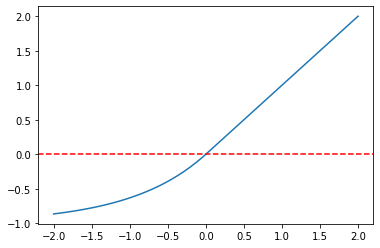

In [128]:
# Plotting ELU function
x = np.linspace(-2, 2)
plt.plot(x, F.elu(torch.Tensor(x)))
plt.axhline(0, c='r', ls='--')

We shift it by 1 to ensure it will always remain positive

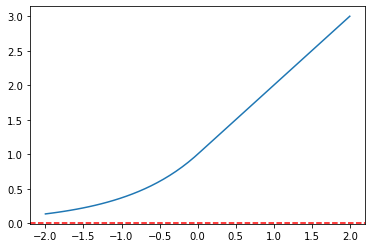

In [130]:
# Plotting ELU+1 function
x = np.linspace(-2, 2)
plt.plot(x, F.elu(torch.Tensor(x))+1)
plt.axhline(0, c='r', ls='--')

Overall, it can be seen that a linear-nonlinear is nothing more than a single linear layer on flattened image, followed by a nonlinear activation. Now let's go ahead and implment this away.

### Implementation

We therefore go ahead and implement a simple network consisting of a linear layer followed by ELU + 1 activation

In [197]:
class Linear(nn.Module):
    def __init__(
        self,
        input_height,
        input_width,
        n_neurons,
        momentum=0.1,
        init_std=1e-3,
        gamma=0.0,
    ):
        super().__init__()
        self.bn = nn.BatchNorm2d(1, momentum=momentum, affine=False)
        self.linear = nn.Linear(input_height * input_width, n_neurons)
        self.gamma = gamma
        self.init_std = init_std
        self.initialize()
        

    def initialize(self, std=None):
        if std is None:
            std = self.init_std
        nn.init.normal_(self.linear.weight.data, std=std)

    def forward(self, x):
        x = self.bn(x)
        x = self.linear(x.flatten(1))
        return nn.functional.elu(x) + 1

    def regularizer(self):
        return self.gamma * self.linear.weight.abs().sum()


And that's it! We have now designed our first network model of the neuron's responses!

Now let's instantiate the model:

In [211]:
ln_model = Linear(input_height=64, input_width=36, n_neurons=5335, gamma=0.1)

### Training the network

Now that we have a candidate model designed, it's time to train it. While we could use standard set of optimizers as provided by PyTorch to implement our training routine, here we are provided with a convenience function `train_model` that would handle a lot of the training boiler plate.

Critically, `train_model` sets up training based on **Poisson loss** and also perform early stopping based on **correlation** of the predicted neuronal responses with the actual neuronal responses on the **validation set**.

In [198]:
from lviv.trainers import train_model

In [200]:
score, output, model_state = train_model(model=model, dataloader=dataloaders)

Epoch 1: 100%|██████████| 75/75 [00:00<00:00, 88.16it/s]


[001|00/05] ---> 0.07587053626775742


Epoch 2: 100%|██████████| 75/75 [00:00<00:00, 83.22it/s]


[002|01/05] -/-> 0.07367712259292603


Epoch 3: 100%|██████████| 75/75 [00:00<00:00, 88.26it/s]


[003|01/05] ---> 0.08224969357252121


Epoch 4: 100%|██████████| 75/75 [00:00<00:00, 84.90it/s]


[004|00/05] ---> 0.08599479496479034


Epoch 5: 100%|██████████| 75/75 [00:00<00:00, 86.38it/s]


[005|01/05] -/-> 0.08449175953865051


Epoch 6: 100%|██████████| 75/75 [00:00<00:00, 84.24it/s]


[006|01/05] ---> 0.086402028799057


Epoch 7: 100%|██████████| 75/75 [00:00<00:00, 88.43it/s]


[007|00/05] ---> 0.08748223632574081


Epoch 8: 100%|██████████| 75/75 [00:00<00:00, 84.70it/s]


[008|00/05] ---> 0.08990668505430222


Epoch 9: 100%|██████████| 75/75 [00:00<00:00, 87.29it/s]


[009|01/05] -/-> 0.08071448653936386


Epoch 10: 100%|██████████| 75/75 [00:00<00:00, 86.94it/s]


[010|02/05] -/-> 0.08513043075799942


Epoch 11: 100%|██████████| 75/75 [00:00<00:00, 86.16it/s]


[011|03/05] -/-> 0.08720102161169052


Epoch 12: 100%|██████████| 75/75 [00:00<00:00, 81.06it/s]


[012|04/05] -/-> 0.08404049277305603


Epoch 13: 100%|██████████| 75/75 [00:00<00:00, 84.35it/s]


[013|05/05] -/-> 0.08473335951566696


Epoch 14:  12%|█▏        | 9/75 [00:00<00:00, 85.97it/s]

Restoring best model after lr decay! 0.084733 ---> 0.089907


Epoch 14: 100%|██████████| 75/75 [00:00<00:00, 85.36it/s]


Epoch    14: reducing learning rate of group 0 to 1.5000e-03.
[014|01/05] -/-> 0.0801103338599205


Epoch 15: 100%|██████████| 75/75 [00:00<00:00, 88.37it/s]


[015|01/05] ---> 0.11031609773635864


Epoch 16: 100%|██████████| 75/75 [00:00<00:00, 82.33it/s]


[016|01/05] -/-> 0.10734045505523682


Epoch 17: 100%|██████████| 75/75 [00:00<00:00, 84.64it/s]


[017|02/05] -/-> 0.10760583728551865


Epoch 18: 100%|██████████| 75/75 [00:00<00:00, 88.15it/s]


[018|03/05] -/-> 0.1077333316206932


Epoch 19: 100%|██████████| 75/75 [00:00<00:00, 88.45it/s]


[019|04/05] -/-> 0.10560315102338791


Epoch 20: 100%|██████████| 75/75 [00:00<00:00, 86.73it/s]


[020|05/05] -/-> 0.10771626234054565


Epoch 21:  12%|█▏        | 9/75 [00:00<00:00, 86.78it/s]

Restoring best model after lr decay! 0.107716 ---> 0.110316


Epoch 21: 100%|██████████| 75/75 [00:00<00:00, 88.35it/s]


Epoch    21: reducing learning rate of group 0 to 4.5000e-04.
[021|01/05] -/-> 0.10827010124921799


Epoch 22: 100%|██████████| 75/75 [00:00<00:00, 87.43it/s]


[022|01/05] ---> 0.11486608535051346


Epoch 23: 100%|██████████| 75/75 [00:00<00:00, 87.24it/s]


[023|01/05] -/-> 0.11383087188005447


Epoch 24: 100%|██████████| 75/75 [00:00<00:00, 87.54it/s]


[024|01/05] ---> 0.11493436992168427


Epoch 25: 100%|██████████| 75/75 [00:00<00:00, 88.45it/s]


[025|00/05] ---> 0.11530203372240067


Epoch 26: 100%|██████████| 75/75 [00:00<00:00, 88.15it/s]


[026|01/05] -/-> 0.11370966583490372


Epoch 27: 100%|██████████| 75/75 [00:00<00:00, 88.33it/s]


[027|02/05] -/-> 0.11223963648080826


Epoch 28: 100%|██████████| 75/75 [00:00<00:00, 88.44it/s]


[028|03/05] -/-> 0.1124301329255104


Epoch 29: 100%|██████████| 75/75 [00:00<00:00, 86.70it/s]


[029|04/05] -/-> 0.11474944651126862


Epoch 30: 100%|██████████| 75/75 [00:00<00:00, 88.17it/s]


[030|05/05] -/-> 0.11435915529727936
Restoring best model after lr decay! 0.114359 ---> 0.115302
Restoring best model! 0.115302 ---> 0.115302


In [191]:
model.linear.weight.shape

torch.Size([5335, 2304])

In [209]:
testset.statistics['images']['all']['mean']

array(111.30036, dtype=float32)

In [210]:
testset.statistics['images']['all']['std']

array(60.936493, dtype=float32)

In [192]:
rfs = model.linear.weight.data.view(5335, 36, 64).to('cpu')

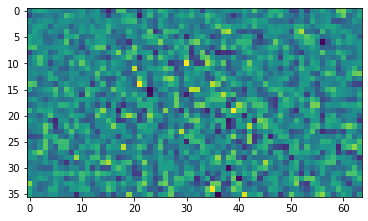

In [196]:
plt.imshow(rfs[111])

In [66]:
import torch
from torch import nn
from collections import OrderedDict
from typing import Iterable

class CNN(nn.Module):
    def __init__(
        self,
        input_height,
        input_width,
        n_neurons,
        input_channels,
        hidden_channels,
        input_kern,
        hidden_kern,
        layers=3,
        momentum=0.1,
        pad_input=True,
        batch_norm=True,
        hidden_dilation=1,
        linear=False,
        readout='fc',
        gamma=0
    ):

        """
        Args:
            input_channels:     Integer, number of input channels as in
            hidden_channels:    Number of hidden channels (i.e feature maps) in each hidden layer
            input_kern:     kernel size of the first layer (i.e. the input layer)
            hidden_kern:    kernel size of each hidden layer's kernel
            layers:         number of layers
            momentum:       BN momentum
            pad_input:      Boolean, if True, applies zero padding to all convolutions
            batch_norm:     Boolean, if True appends a BN layer after each convolutional layer
            hidden_dilation:   If set to > 1, will apply dilated convs for all hidden layers
            linear:         Boolean, if True, remove all nonlinearity in the model
            readout:
        """
        super().__init__()
        self.layers = layers
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.core = nn.Sequential()
        self.readout_type = readout
        self.n_neurons = n_neurons
        self.gamma = gamma


        # Core: --- first layer
        layer = OrderedDict()
        layer["conv"] = nn.Conv2d(
            input_channels, hidden_channels, input_kern, padding=input_kern // 2 if pad_input else 0, bias=False
        )
        if batch_norm:
            layer["norm"] = nn.BatchNorm2d(hidden_channels, momentum=momentum)
        if not linear:
            layer["nonlin"] = nn.ELU(inplace=True)
        self.core.add_module("layer0", nn.Sequential(layer))
        if not isinstance(hidden_kern, Iterable):
            hidden_kern = [hidden_kern] * (self.layers - 1)

        # Core: --- other layers
        for l in range(1, self.layers):
            layer = OrderedDict()
            hidden_padding = ((hidden_kern[l - 1] - 1) * hidden_dilation + 1) // 2
            layer["conv"] = nn.Conv2d(
                hidden_channels,
                hidden_channels,
                hidden_kern[l - 1],
                padding=hidden_padding,
                bias=False,
                dilation=hidden_dilation,
            )
            if batch_norm:
                layer["norm"] = nn.BatchNorm2d(hidden_channels, momentum=momentum)
            if not linear:
                layer["nonlin"] = nn.ELU(inplace=True)
            self.core.add_module("layer{}".format(l), nn.Sequential(layer))
        self.apply(self.init_conv)
        
        # Readout
        ## fully connected readout
        if readout == 'fc':
            in_dim = self.core_channels * input_height * input_width
            self.readout = nn.Linear(in_dim, n_neurons, bias=True)
        ## spatial separable readout
        elif readout == 'spatial':
            self.spatial = nn.Parameter(torch.Tensor(n_neurons, input_width, input_height))
            self.features = nn.Parameter(torch.Tensor(n_neurons, self.core_channels))
            self.readout_bias = nn.Parameter(torch.Tensor(n_neurons))
            
    def forward(self, input_):
        ret = []
        for l, feat in enumerate(self.core):
            input_ = feat(input_)
            ret.append(input_)
        core_out = torch.cat(ret, dim=1)
        
        if self.readout_type == 'fc':
            core_out = core_out.view([core_out.shape[0], -1])
            readout_out = nn.functional.elu(self.readout(core_out)) + 1
        elif self.readout_type == 'spatial':
            readout_out = torch.einsum("ncwh,owh->nco", core_out, self.spatial)
            readout_out = torch.einsum("nco,oc->no", readout_out, self.features)
            readout_out = readout_out + self.readout_bias
            readout_out = nn.functional.elu(readout_out) + 1
        return readout_out

    def regularizer(self):
        if self.readout_type == 'fc':
            return self.readout.weight.abs().sum() * self.gamma
        elif self.readout_type == 'spatial':
            return (
            self.spatial.view(self.n_neurons, -1).abs().sum(dim=1, keepdim=True)
            * self.features.view(self.n_neurons, -1).abs().sum(dim=1)
        ).sum() * self.gamma

    @property
    def core_channels(self):
        return len(self.core) * self.hidden_channels
    
    @staticmethod
    def init_conv(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0)
                
    def initialize_readout(self):
        if self.readout_type == 'full':
            nn.init.xavier_normal_(self.readout.weight.data)
            self.readout.weight.data.fill_(0)
        elif self.readout_type == 'spatial':
            self.spatial.data.normal_(0, 1e-3)
            self.features.data.normal_(0, 1e-3)
            if self.readout_bias is not None:
                self.readout_bias.data.fill_(0)
                
    def initialize(self):
        self.core.apply(self.init_conv)
        self.initialize_readout()
            


In [8]:
torch.cuda.is_available()

True

In [68]:
neuron_n = 5335
model_config = {
    'input_height': 64,
    'input_width': 36,
    'n_neurons': neuron_n,
    'input_channels': 1,
    'hidden_channels': 64,
    'input_kern': 15,
    'hidden_kern': 13,
    'layers': 4,
    'readout': 'spatial',
    'gamma': 0.001,
}
model = CNN(**model_config)
model.initialize()

# be sure to place it on the GPU!
model.cuda()

CNN(
  (core): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (layer3): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [62]:
from lviv.models import build_lurz2020_model
model_config = {'init_mu_range': 0.55,
                'init_sigma': 0.4,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': {'type': 'cortex',
                                        'input_dimensions': 2,
                                        'hidden_layers': 0,
                                        'hidden_features': 0,
                                        'final_tanh': False},
                'gamma_readout': 2.439,
                'linear': False}

model = build_lurz2020_model(**model_config, dataloaders=dataloaders, seed=1234)

## Build trainer

In [108]:
from lviv.trainers import train_model

trainer_config = {'track_training': True,
                  'detach_core': False}

## Model training
Approximate training time: ~15 mins

In [118]:
model = Linear(input_height=64, input_width=36, n_neurons=5335, gamma=0.000, init_std=0.001)

In [ ]:
score, output, model_state = train_model(model=model, dataloader=dataloaders, seed=1, lr_init=1e-6, **trainer_config)

correlation -8.0261256e-05
poisson_loss 9588915.0


Epoch 1: 100%|██████████| 75/75 [00:00<00:00, 83.59it/s]


[001|00/05] ---> 0.005938975140452385
correlation 0.005938975
poisson_loss 3507831.2


Epoch 2: 100%|██████████| 75/75 [00:00<00:00, 84.14it/s]


[002|00/05] ---> 0.010033603757619858
correlation 0.010033604
poisson_loss 3307697.5


Epoch 3: 100%|██████████| 75/75 [00:00<00:00, 76.13it/s]


[003|00/05] ---> 0.014280364848673344
correlation 0.014280365
poisson_loss 3169816.0


Epoch 4: 100%|██████████| 75/75 [00:00<00:00, 81.75it/s]


[004|00/05] ---> 0.01792152039706707
correlation 0.01792152
poisson_loss 3062201.2


Epoch 5: 100%|██████████| 75/75 [00:00<00:00, 82.33it/s]


[005|00/05] ---> 0.021391743794083595
correlation 0.021391744
poisson_loss 2986927.5


Epoch 6: 100%|██████████| 75/75 [00:00<00:00, 83.91it/s]


[006|00/05] ---> 0.02431696094572544
correlation 0.024316961
poisson_loss 2923228.5


Epoch 7: 100%|██████████| 75/75 [00:00<00:00, 79.99it/s]


[007|00/05] ---> 0.02730812504887581
correlation 0.027308125
poisson_loss 2877410.0


Epoch 8: 100%|██████████| 75/75 [00:00<00:00, 82.01it/s]


[008|00/05] ---> 0.02922097034752369
correlation 0.02922097
poisson_loss 2835198.5


Epoch 9:  83%|████████▎ | 62/75 [00:00<00:00, 84.83it/s]

In [103]:
model.bn.bias

Parameter containing:
tensor([0.1460], device='cuda:0', requires_grad=True)

In [104]:
model.bn.weight

Parameter containing:
tensor([0.2764], device='cuda:0', requires_grad=True)

In [105]:
model.bn??

Signature:      model.bn(*input, **kwargs)
Type:           BatchNorm2d
String form:    BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
File:           /usr/local/lib/python3.8/dist-packages/torch/nn/modules/batchnorm.py
Source:        
class BatchNorm2d(_BatchNorm):
    r"""Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs
    with additional channel dimension) as described in the paper
    `Batch Normalization: Accelerating Deep Network Training by Reducing
    Internal Covariate Shift <https://arxiv.org/abs/1502.03167>`__ .

    .. math::

        y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta

    The mean and standard-deviation are calculated per-dimension over
    the mini-batches and :math:`\gamma` and :math:`\beta` are learnable parameter vectors
    of size `C` (where `C` is the input size). By default, the elements of :math:`\gamma` are set
    to 1 and the elements of :math:`\beta` are set 